# ODE Discovery with SINDy-style Sparse Regression

This notebook demonstrates how to discover governing ordinary differential equations (ODEs)
from time-series data using JAXSR's dynamics module. The approach is inspired by
[SINDy](https://www.pnas.org/doi/10.1073/pnas.1517384113) (Sparse Identification of Nonlinear
Dynamics), which frames ODE discovery as a sparse regression problem.

The idea: given time-series measurements of state variables $\mathbf{X}(t)$, we:

1. **Estimate derivatives** $\dot{\mathbf{X}} = d\mathbf{X}/dt$ from the data
2. **Build a library** of candidate nonlinear functions of $\mathbf{X}$
3. **Fit a sparse model** $\dot{x}_i = \Theta(\mathbf{X})\,\boldsymbol{\xi}_i$ for each state variable

JAXSR wraps this workflow in three functions:
- `estimate_derivatives()` — numerical differentiation (finite difference, Savitzky-Golay, or spline)
- `discover_dynamics()` — end-to-end ODE discovery
- `DynamicsResult` — result container with models, equations, and metrics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

from jaxsr import BasisLibrary, discover_dynamics, estimate_derivatives

## 1. Exponential Decay: A Single ODE

The simplest test case. The true system is:

$$\frac{dx}{dt} = -0.5\,x, \qquad x(0) = 5$$

The exact solution is $x(t) = 5\,e^{-0.5t}$.

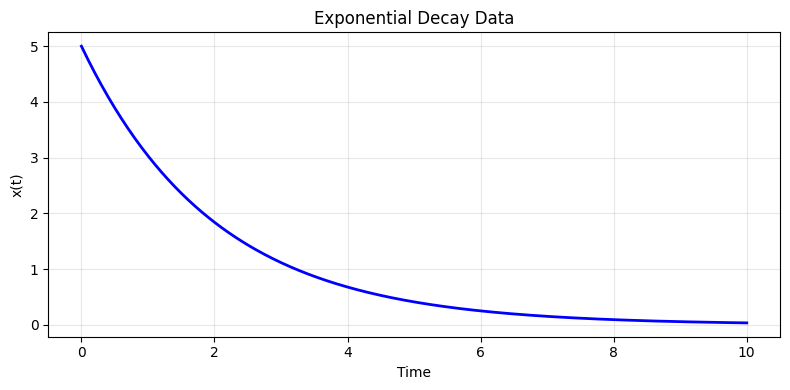

In [2]:
# Generate clean data from the exact solution
t_decay = np.linspace(0, 10, 300)
X_decay = (5.0 * np.exp(-0.5 * t_decay)).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_decay, X_decay, "b-", linewidth=2)
ax.set_xlabel("Time")
ax.set_ylabel("x(t)")
ax.set_title("Exponential Decay Data")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
result_decay = discover_dynamics(
    X_decay,
    t_decay,
    state_names=["x"],
    max_terms=3,
    strategy="greedy_forward",
    information_criterion="bic",
)

print(result_decay.summary())

Discovered ODEs
d(x)/dt = y = - 0.4993*x + 0.0001521*x^3 - 0.0007599*x^2
  R² = 1.0000, MSE = 1.19e-06, AIC = -3234.7, BIC = -3223.6


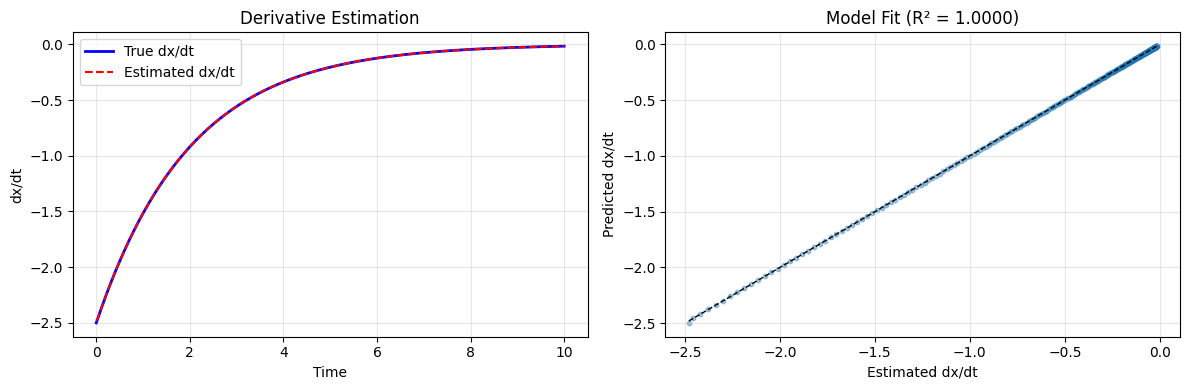

In [4]:
# Compare estimated vs true derivatives
dxdt_true = -0.5 * X_decay[:, 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t_decay, dxdt_true, "b-", label="True dx/dt", linewidth=2)
axes[0].plot(t_decay, result_decay.derivatives[:, 0], "r--", label="Estimated dx/dt", linewidth=1.5)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("dx/dt")
axes[0].set_title("Derivative Estimation")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Parity plot: predicted vs estimated derivatives
model_x = result_decay.models["x"]
dxdt_pred = np.asarray(model_x.predict(X_decay))
axes[1].scatter(result_decay.derivatives[:, 0], dxdt_pred, alpha=0.4, s=10)
lims = [result_decay.derivatives[:, 0].min(), result_decay.derivatives[:, 0].max()]
axes[1].plot(lims, lims, "k--", linewidth=1)
axes[1].set_xlabel("Estimated dx/dt")
axes[1].set_ylabel("Predicted dx/dt")
axes[1].set_title(f"Model Fit (R\u00b2 = {result_decay.metrics['x']['r2']:.4f})")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Comparing Derivative Estimation Methods

The quality of derivative estimates directly affects ODE discovery. JAXSR provides
three methods:

| Method | Pros | Cons |
|--------|------|------|
| `finite_difference` | Works with non-uniform spacing | Lower accuracy, amplifies noise |
| `savgol` | Good noise smoothing | Requires uniform spacing |
| `spline` | High accuracy on smooth data | Can overfit noisy data |

Let's compare them on sinusoidal data where we know the exact derivatives.

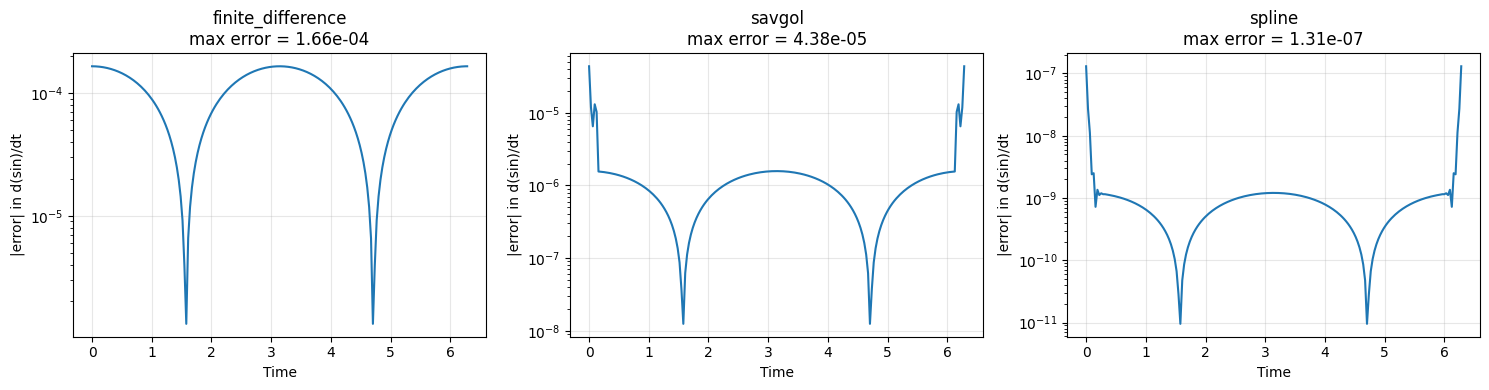

In [5]:
t_sin = np.linspace(0, 2 * np.pi, 200)
X_sin = np.column_stack([np.sin(t_sin), np.cos(t_sin)])
dXdt_exact = np.column_stack([np.cos(t_sin), -np.sin(t_sin)])

methods = {
    "finite_difference": {},
    "savgol": {"window_length": 11, "polyorder": 3},
    "spline": {"smooth": 0.0},
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (method, kwargs) in zip(axes, methods.items(), strict=False):
    dXdt = estimate_derivatives(X_sin, t_sin, method=method, **kwargs)
    error = np.abs(dXdt[:, 0] - dXdt_exact[:, 0])
    ax.semilogy(t_sin, error, linewidth=1.5)
    ax.set_title(f"{method}\nmax error = {error.max():.2e}")
    ax.set_xlabel("Time")
    ax.set_ylabel("|error| in d(sin)/dt")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Lotka-Volterra Predator-Prey Equations

A classic coupled nonlinear ODE system:

$$\frac{dx}{dt} = \alpha\,x - \beta\,x\,y$$
$$\frac{dy}{dt} = -\gamma\,y + \delta\,x\,y$$

With parameters $\alpha = 1.0$, $\beta = 0.5$, $\gamma = 0.75$, $\delta = 0.25$.

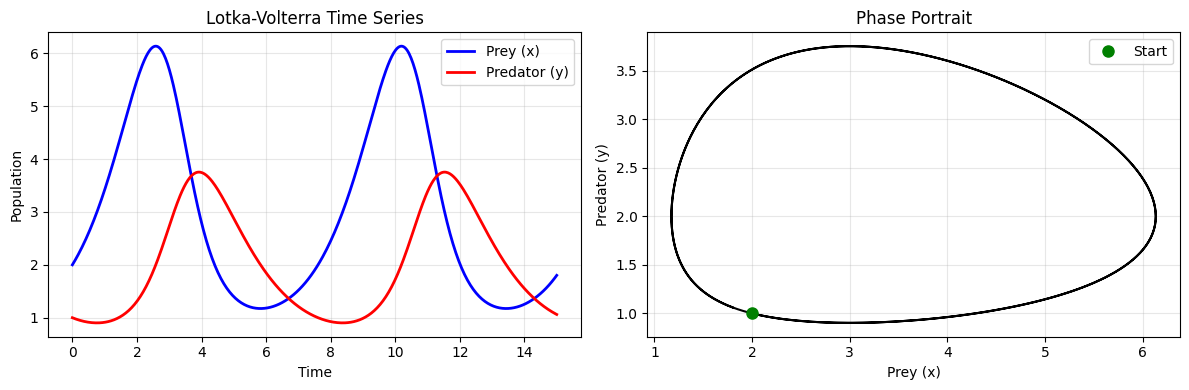

In [6]:
def lotka_volterra(t, z):
    x, y = z
    return [1.0 * x - 0.5 * x * y, -0.75 * y + 0.25 * x * y]


sol = solve_ivp(
    lotka_volterra, [0, 15], [2.0, 1.0],
    t_eval=np.linspace(0, 15, 500), rtol=1e-10,
)
t_lv = sol.t
X_lv = sol.y.T  # shape (500, 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t_lv, X_lv[:, 0], "b-", label="Prey (x)", linewidth=2)
axes[0].plot(t_lv, X_lv[:, 1], "r-", label="Predator (y)", linewidth=2)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].set_title("Lotka-Volterra Time Series")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(X_lv[:, 0], X_lv[:, 1], "k-", linewidth=1.5)
axes[1].plot(X_lv[0, 0], X_lv[0, 1], "go", markersize=8, label="Start")
axes[1].set_xlabel("Prey (x)")
axes[1].set_ylabel("Predator (y)")
axes[1].set_title("Phase Portrait")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
result_lv = discover_dynamics(
    X_lv,
    t_lv,
    state_names=["x", "y"],
    max_terms=5,
    strategy="greedy_forward",
    information_criterion="bic",
)

print(result_lv.summary())
print()
print("True equations:")
print("  d(x)/dt =  1.00*x - 0.50*x*y")
print("  d(y)/dt = -0.75*y + 0.25*x*y")

Discovered ODEs
d(x)/dt = y = 1.6101e-05*y^3 + 0.001921 - 0.001074*y - 0.4997*x*y + 0.9993*x
  R² = 1.0000, MSE = 5.17e-07, AIC = -5808.3, BIC = -5787.3
d(y)/dt = y = - 2.6286e-06*x^3 - 0.00099 + 0.0003775*x + 0.2498*x*y - 0.7495*y
  R² = 1.0000, MSE = 1.04e-07, AIC = -6611.2, BIC = -6590.2

True equations:
  d(x)/dt =  1.00*x - 0.50*x*y
  d(y)/dt = -0.75*y + 0.25*x*y


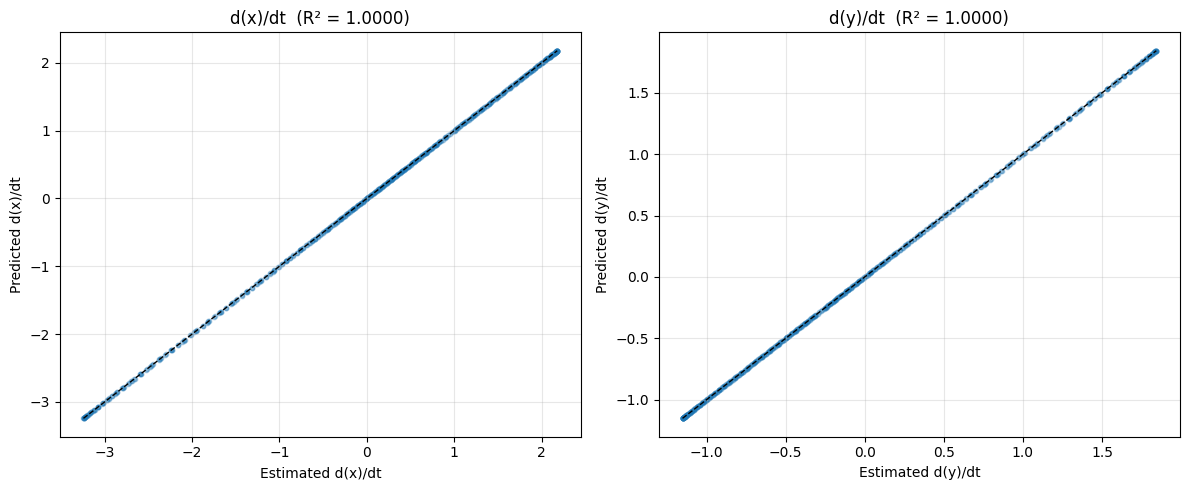

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, ax) in enumerate(zip(["x", "y"], axes, strict=True)):
    model_i = result_lv.models[name]
    dxdt_est = result_lv.derivatives[:, i]
    dxdt_pred = np.asarray(model_i.predict(X_lv))

    ax.scatter(dxdt_est, dxdt_pred, alpha=0.3, s=10)
    lims = [min(dxdt_est.min(), dxdt_pred.min()), max(dxdt_est.max(), dxdt_pred.max())]
    ax.plot(lims, lims, "k--", linewidth=1)
    r2 = result_lv.metrics[name]["r2"]
    ax.set_xlabel(f"Estimated d({name})/dt")
    ax.set_ylabel(f"Predicted d({name})/dt")
    ax.set_title(f"d({name})/dt  (R\u00b2 = {r2:.4f})")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Noisy Data: Damped Harmonic Oscillator

Real data is noisy. Let's test ODE discovery on a damped oscillator with added measurement noise.

The true system (written as two first-order ODEs):

$$\frac{dx_1}{dt} = x_2, \qquad \frac{dx_2}{dt} = -0.5\,x_2 - 2.0\,x_1$$

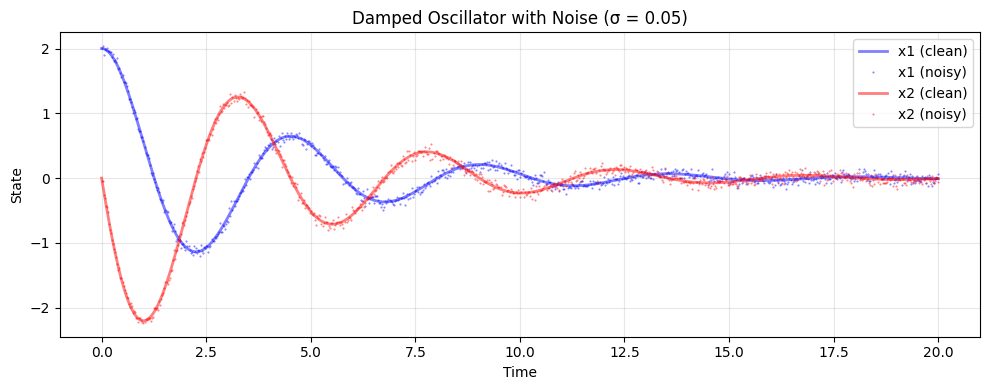

In [9]:
def damped_oscillator(t, z):
    x1, x2 = z
    return [x2, -0.5 * x2 - 2.0 * x1]


sol_osc = solve_ivp(
    damped_oscillator, [0, 20], [2.0, 0.0],
    t_eval=np.linspace(0, 20, 800), rtol=1e-10,
)
t_osc = sol_osc.t
X_osc_clean = sol_osc.y.T

# Add measurement noise
rng = np.random.default_rng(42)
noise_level = 0.05
X_osc = X_osc_clean + noise_level * rng.standard_normal(X_osc_clean.shape)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t_osc, X_osc_clean[:, 0], "b-", label="x1 (clean)", linewidth=2, alpha=0.5)
ax.plot(t_osc, X_osc[:, 0], "b.", markersize=1, label="x1 (noisy)", alpha=0.5)
ax.plot(t_osc, X_osc_clean[:, 1], "r-", label="x2 (clean)", linewidth=2, alpha=0.5)
ax.plot(t_osc, X_osc[:, 1], "r.", markersize=1, label="x2 (noisy)", alpha=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("State")
ax.set_title(f"Damped Oscillator with Noise (\u03c3 = {noise_level})")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

With noisy data, the Savitzky-Golay filter is a better choice for derivative estimation
because it smooths the noise before differentiating.

In [10]:
result_osc = discover_dynamics(
    X_osc,
    t_osc,
    state_names=["x1", "x2"],
    max_terms=4,
    strategy="greedy_forward",
    information_criterion="bic",
    derivative_method="savgol",
    derivative_kw={"window_length": 15, "polyorder": 3},
)

print(result_osc.summary())
print()
print("True equations:")
print("  d(x1)/dt =  1.0*x2")
print("  d(x2)/dt = -0.5*x2 - 2.0*x1")

Discovered ODEs
d(x1)/dt = y = 0.9994*x2
  R² = 0.7851, MSE = 1.07e-01, AIC = 486.8, BIC = 491.5
d(x2)/dt = y = - 1.943*x1 - 0.4752*x2
  R² = 0.8898, MSE = 9.68e-02, AIC = 406.1, BIC = 415.5

True equations:
  d(x1)/dt =  1.0*x2
  d(x2)/dt = -0.5*x2 - 2.0*x1


## 5. Custom Basis Library

By default, `discover_dynamics` builds a library with constant, polynomial (up to degree 3),
and pairwise interaction terms. You can pass a custom `BasisLibrary` if you have domain
knowledge about the expected form of the equations.

For example, for a cubic oscillator (Duffing equation):

$$\frac{dx_1}{dt} = x_2, \qquad \frac{dx_2}{dt} = -\delta\,x_2 - \alpha\,x_1 - \beta\,x_1^3$$

In [11]:
alpha, beta, delta = 1.0, 0.2, 0.3


def duffing(t, z):
    x1, x2 = z
    return [x2, -delta * x2 - alpha * x1 - beta * x1**3]


sol_duf = solve_ivp(
    duffing, [0, 30], [1.5, 0.0],
    t_eval=np.linspace(0, 30, 1000), rtol=1e-10,
)
t_duf = sol_duf.t
X_duf = sol_duf.y.T

# Custom library: only include the terms we expect might appear
lib_duf = (
    BasisLibrary(n_features=2, feature_names=["x1", "x2"])
    .add_constant()
    .add_linear()                     # x1, x2
    .add_polynomials(max_degree=3)    # x1^2, x1^3, x2^2, x2^3
    .add_interactions(max_order=2)    # x1*x2
)
print(f"Custom library has {len(lib_duf)} candidate functions")

result_duf = discover_dynamics(
    X_duf,
    t_duf,
    state_names=["x1", "x2"],
    basis_library=lib_duf,
    max_terms=5,
    strategy="greedy_forward",
    information_criterion="bic",
)

print()
print(result_duf.summary())
print()
print("True equations:")
print(f"  d(x1)/dt = x2")
print(f"  d(x2)/dt = -{delta}*x2 - {alpha}*x1 - {beta}*x1^3")

Custom library has 8 candidate functions



Discovered ODEs
d(x1)/dt = y = 0.9997*x2 - 0.0005391*x1^3 - 0.0009059*x1*x2 - 0.0004705*x1^2
  R² = 1.0000, MSE = 9.72e-07, AIC = -10997.9, BIC = -10978.2
d(x2)/dt = y = - x1 - 0.2998*x2 - 0.1996*x1^3 + 0.0003723*x1*x2 + 0.000117*x1^2
  R² = 1.0000, MSE = 8.83e-08, AIC = -13394.4, BIC = -13369.9

True equations:
  d(x1)/dt = x2
  d(x2)/dt = -0.3*x2 - 1.0*x1 - 0.2*x1^3


## 6. Simulating the Discovered Equations

A strong validation is to integrate the discovered ODEs forward in time and compare
the trajectories against the original data.

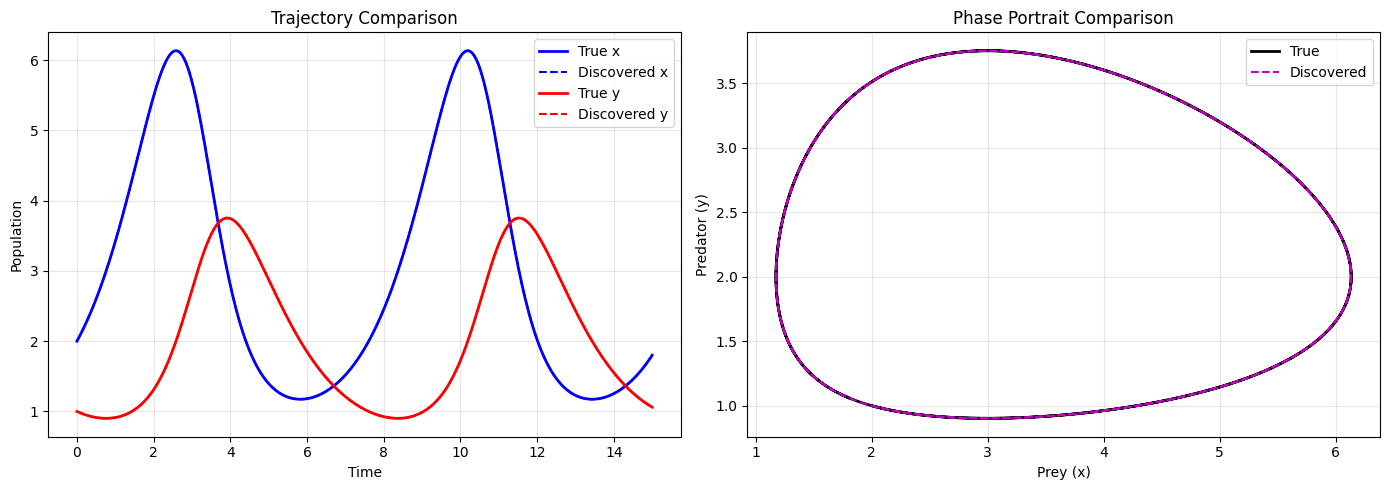

In [12]:
# Use the Lotka-Volterra result to simulate forward
model_x = result_lv.models["x"]
model_y = result_lv.models["y"]


def discovered_rhs(t, z):
    """Right-hand side using discovered models."""
    state = np.array(z).reshape(1, -1)
    dxdt = float(model_x.predict(state)[0])
    dydt = float(model_y.predict(state)[0])
    return [dxdt, dydt]


sol_disc = solve_ivp(
    discovered_rhs, [0, 15], [2.0, 1.0],
    t_eval=t_lv, rtol=1e-8,
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(t_lv, X_lv[:, 0], "b-", label="True x", linewidth=2)
axes[0].plot(sol_disc.t, sol_disc.y[0], "b--", label="Discovered x", linewidth=1.5)
axes[0].plot(t_lv, X_lv[:, 1], "r-", label="True y", linewidth=2)
axes[0].plot(sol_disc.t, sol_disc.y[1], "r--", label="Discovered y", linewidth=1.5)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].set_title("Trajectory Comparison")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(X_lv[:, 0], X_lv[:, 1], "k-", label="True", linewidth=2)
axes[1].plot(sol_disc.y[0], sol_disc.y[1], "m--", label="Discovered", linewidth=1.5)
axes[1].set_xlabel("Prey (x)")
axes[1].set_ylabel("Predator (y)")
axes[1].set_title("Phase Portrait Comparison")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

| Function | Purpose |
|----------|--------|
| `estimate_derivatives(X, t, method)` | Compute dX/dt from time-series data |
| `discover_dynamics(X, t, ...)` | End-to-end ODE discovery |
| `DynamicsResult.summary()` | Human-readable output |

**Tips for best results:**

- Use `derivative_method="savgol"` for noisy data
- Use `derivative_method="spline"` for clean, smooth data
- Pass a custom `basis_library` if you have domain knowledge about expected terms
- Validate by simulating the discovered ODEs forward in time
- For highly stiff or chaotic systems, use more data points and a smaller time interval

## References

The SINDy approach used in this notebook builds on a rich literature connecting sparse
regression, neural networks, and dynamical systems discovery:

1. **Brunton, S. L., Proctor, J. L., & Kutz, J. N.** (2016).
   Discovering governing equations from data by sparse identification of nonlinear
   dynamical systems. *PNAS*, 113(15), 3932-3937.
   [doi:10.1073/pnas.1517384113](https://www.pnas.org/doi/10.1073/pnas.1517384113)
   — The original SINDy paper that introduced sparse regression for ODE discovery.

2. **Chen, R. T. Q., Rubanova, Y., Bettencourt, J., & Duvenaud, D.** (2018).
   Neural Ordinary Differential Equations. *NeurIPS 2018* (Best Paper Award).
   [arXiv:1806.07366](https://arxiv.org/abs/1806.07366)
   — Parameterizes dynamics with neural networks and solves with ODE integrators;
   an alternative to SINDy that trades interpretability for flexibility.

3. **Cranmer, M., Sanchez Gonzalez, A., Battaglia, P., et al.** (2020).
   Discovering Symbolic Models from Deep Learning with Inductive Biases. *NeurIPS 2020*.
   [arXiv:2006.11287](https://arxiv.org/abs/2006.11287)
   — Distills interpretable symbolic expressions from graph neural networks, bridging
   neural ODEs and symbolic regression.

4. **Cranmer, M.** (2023).
   Interpretable Machine Learning for Science with PySR and SymbolicRegression.jl.
   [arXiv:2305.01582](https://arxiv.org/abs/2305.01582)
   — High-performance symbolic regression via evolutionary search; a complementary
   approach to the sparse-regression method used here.

5. **Lemos, P., Jeffrey, N., Cranmer, M., Ho, S., & Battaglia, P.** (2023).
   Rediscovering orbital mechanics with machine learning.
   *Machine Learning: Science and Technology*, 4(4), 045002.
   [arXiv:2202.02306](https://arxiv.org/abs/2202.02306)
   — Recovers Newton's law of gravitation from solar system trajectory data using
   graph neural networks and symbolic regression.

6. **Nayek, R., Worden, K., & Cross, E. J.** (2025).
   An Empirical Investigation of Neural ODEs and Symbolic Regression for
   Dynamical Systems.
   [arXiv:2601.20637](https://arxiv.org/abs/2601.20637)
   — Compares neural ODEs and symbolic regression for discovering governing equations,
   showing that NODEs can augment data for symbolic regression on noisy systems.